In [1]:
include("notebook_preamble.jl");

In [2]:
using SymPy;
include("TransverseIsingModels.jl")
using .TransverseIsingModels
TIM = TransverseIsingModels;

## Computation of jump operators

In [3]:
⊗ₖ = kron;

In [4]:
const σ0 = [1 0; 0 1];
const σx = [0 1; 1 0];
const σy = [0 -im; im 0];
const σz = [1 0; 0 -1];
const σp = [0 1; 0 0];
const σm = [0 0; 1 0];

In [5]:
function symeigen(H)
    symeig = H.eigenvects()
    vals, vecs = eltype(H)[], []
    for (λ, _, vs) in symeig
        for v in vs
            push!(vals, λ)
            push!(vecs, vec(v))
        end
    end
    vals, vecs
end;

In [6]:
function addentry!(dict, key, value; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            push!(dict[k], value)
            return dict
        end
    end
    dict[key] = [value]
    dict
end;

In [7]:
firstvalue(i, (x, y)) = x
lastvalue(i, (x, y)) = y
function dictby(A; isequal=isequal, keyof=firstvalue, valof=lastvalue)
    i0, x0 = 1, first(A)
    k0, v0 = keyof(i0, x0), valof(i0, x0)
    dict = Dict(k0 => typeof(v0)[])
    dict = Dict()
    for (i, x) in enumerate(A)
        k, v = keyof(i, x), valof(i, x)
        addentry!(dict, k, v, isequal=isequal)
    end
    dict
end;

In [8]:
import QuantumOpticsBase.projector
projector(ψ::AbstractVector) = ψ * ψ';

In [9]:
function incentry!(dict, key; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            dict[k] += 1
            return dict
        end
    end
    dict[key] = 1
    dict
end;

In [10]:
function combinejumps(Js)
    d = Dict()
    for J in Js
        incentry!(d, J)
    end
    [√(one(eltype(J)) * N)*J for (J, N) in d]
end;

In [11]:
function jumps(vals, vecs, As; combine=true, isequal=isequal)
    eigendict = dictby(zip(vals, vecs))
    ωs = dictby(((E2 - E1, (E1, E2)) for E1 in keys(eigendict) for E2 in keys(eigendict)), isequal=isequal)
    Πs = TIM.projectors(eigendict)
    Jωs = dictmap(ΔEs -> filter(x -> !isequal(x, zero(x)), [simplify.(sum(Πs[E1]*A*Πs[E2] for (E1, E2) in ΔEs)) for A in As]), ωs)
    combine ? dictmap(combinejumps, Jωs) : Jωs
end
dipolejumps(vals, vecs; kwargs...) = jumps(vals, vecs,
    [σx ⊗ₖ σ0,  σy ⊗ₖ σ0,  σz ⊗ₖ σ0, σ0 ⊗ₖ σx,  σ0 ⊗ₖ σy,  σ0 ⊗ₖ σz];
    kwargs...);

In [12]:
@vars s1p=>"σ₁⁺" s1m=>"σ₁⁻" commutative=false
@vars s2p=>"σ₂⁺" s2m=>"σ₂⁻" commutative=false
@vars s1x=>"σ₁ˣ" s2x=>"σ₂ˣ" commutative=false
@vars s1y=>"σ₁ʸ" s2y=>"σ₂ʸ" commutative=false
@vars s1z=>"σ₁ᶻ" s2z=>"σ₂ᶻ" commutative=false
@vars n1 =>"n₁"   n2=>"n₂"  commutative=false
@vars g d real=true;

In [13]:
spinops = [s1p, s1m, s2p, s2m, s1x, s2x, s1y, s2y, s1z, s2z, n1, n2];
_symspinop = cat([n1 s1p; s1m (1 - n1)], [n2 s2p; s2m (1 - n2)], dims=3)
_dummy_spinop = Dict(s => sympy.Dummy(s.name) for s in spinops);
site_collect_ops(siteops) = push!([_dummy_spinop[op] for op in siteops], 1)
_collect_ops = [a * b for a in site_collect_ops([s1p, s1m, n1]) for b in site_collect_ops([s2p, s2m, n2])];

In [14]:
u, v, w = Wild(:u), Wild(:v), Wild(:w);

In [15]:
symspinop(l, r, i) = _symspinop[l+1, r+1, i];
function jumpsimplify(J)
    s = mapreduce(+, CartesianIndices(J)[J .!= 0]) do I
        x = J[I]
        i, j = Tuple(I - CartesianIndex(1, 1))
        x * symspinop(i÷2, j÷2, 1) * symspinop(i%2, j%2, 2)
    end
    s = subs(expand(s), √(g^2 + 1) => d)
    s = s.simplify()
    s = s.xreplace(_dummy_spinop)
    for op in _collect_ops
        s = s.collect(op)
    end
    s.simplify()
end;

In [16]:
=>ₛ(a, b) = _dummy_spinop[a] => b
thesis_latex(J) = sympy.latex(J,
        imaginary_unit = "\\im",
        symbol_names = Dict(
            g   =>  "g",
            d   =>  "d",
            n1  =>ₛ "\\opr{n}_1",
            n2  =>ₛ "\\opr{n}_2",
            s1p =>ₛ "\\pauli_1^+",
            s2p =>ₛ "\\pauli_2^+",
            s1m =>ₛ "\\pauli_1^-",
            s2m =>ₛ "\\pauli_2^-",
        ));

In [17]:
function save_jump_latex(path, sJωs)
    open(path, "w") do file
        for (ω, Js) in sJωs
            sω = factor(subs(expand(ω), √(g^2 + 1) => d))
            println(file, thesis_latex(sω))
            println(file, " \\\\")
            for J in Js
                println(file, thesis_latex(J))
                println(file, " \\\\")
            end
            println(file, " \\\\")
        end
    end
end;

## Nondegenerate jump operators

In [18]:
H = -2*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)

4×4 Array{Sym,2}:
 -2⋅g   0   0   -2
    0   0  -2    0
    0  -2   0    0
   -2   0   0  2⋅g

In [197]:
sJωs = dictmap(Js -> jumpsimplify.(Js), dipolejumps(symeigen(H)...; combine=true))
save_jump_latex("nondegen-jumps.tex", sJωs)

## Degenerate jump operators

In [20]:
H0 = subs.(-2*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => 0)

4×4 Array{Sym,2}:
  0   0   0  -2
  0   0  -2   0
  0  -2   0   0
 -2   0   0   0

In [198]:
sJωs0 = dictmap(Js -> jumpsimplify.(Js), dipolejumps(symeigen(H0)...; combine=true))
save_jump_latex("degen-jumps.tex", sJωs0)

## Liouvillian

In [22]:
leftmul(A)  = one(A) ⊗ₖ A
rightmul(A) = permutedims(A) ⊗ₖ one(A)
commwith(A) = leftmul(A) - rightmul(A)
acommwith(A) = leftmul(A) + rightmul(A);

In [26]:
nB(ω, β) = 1 / (exp(β*ω) - 1)
γdiv(ω; β) = isapprox(ω, 0, atol=1e-9) ? 0 : ω^3 * (nB(ω, β) + 1)
𝒟term(J, γ) = γ * (leftmul(J) * rightmul(J') - acommwith(J' * J) / 2)
𝒟(Jωs, γ; params...) = sum(𝒟term(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);

Leaving the coefficients $S(\omega)$ aside, the Lamb shift Hamiltonian is roughly like

In [81]:
# proxyHLS = -im * sum(commwith(J' * J) for (ω, Js) in Jωs for J in Js);

In [300]:
function numeigen(H)
    vals, vecs = eigen(H)
    vals, eachcol(vecs)
end

isequalto(atol=1e-9) = (x, y) -> isapprox(x, y, atol=atol)

function dissipation_rates(H, dict, γ; params...)
    Jωs = dipolejumps(numeigen(N.(subs.(H, dict)))...;
        combine=true, isequal=isequalto())
    dissipator = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(𝒟(Jωs, γ; params...))
    eigvals(dissipator)
end;

In [365]:
function plot_rates(g0s, β; kwargs...)
    maxrates_ising = [real(dissipation_rates(-g*(σx ⊗ₖ σx) - (σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => g0, γdiv, β = β)) for g0 in g0s]
    maxrates_free = [real(dissipation_rates(-Sym(1)*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => g0, γdiv, β = β)) for g0 in g0s];

    plot(g0s, -hcat(maxrates_ising...)'[:,1:end-1],
        title=L"\beta = %$β",
        color=:black,
        alpha=0.25;
        kwargs...)

    plot!(g0s, -hcat(maxrates_free...)'[:,1:end-1],
        color=RGB(0.7, 0.05, 0.0),
        # Changing alpha is slow to compile with pgfplots.
        alpha=0.5*exp.(-range(0, stop=10, length=length(g0s)))
    )
end;

In [366]:
g0s = 10 .^ range(-2, 1, length=64);
βs = [1e-1, 2e-1, 5e-1, 1e0, 2e0, 5e0]
rate_plots = [plot_rates(g0s, β) for β in βs];

In [307]:
import Plots.PlotMeasures: pt;

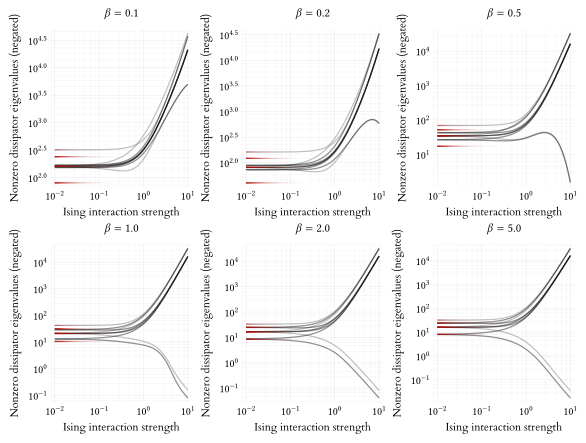

In [367]:
plot(rate_plots..., layout=(2, 3), size=(800, 600),
        xlabel="Ising interaction strength",
        ylabel="Nonzero dissipator eigenvalues (negated)",
        top_margin=6pt,
        bottom_margin=6pt,
        xscale=:log10,
        yscale=:log10,
        key=false)